In [10]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.ticker import MultipleLocator

# Parameters
folder = 'f15000'
file_pattern = os.path.join(folder, 'data*.lvm')

# Load all data files and concatenate into a single array
all_data = []
file_list = sorted(glob.glob(file_pattern))
print(file_list)
for fname in file_list:
    data = np.loadtxt(fname, skiprows=22)
    velocities = data[:, 1].astype(float)
    all_data.append(velocities)
all_data = np.concatenate(all_data)
total_mean = np.mean(all_data)
total_var = np.var(all_data)

print(f"Mean: {total_mean}, Variance: {total_var}")

['f15000/data0.lvm', 'f15000/data1.lvm', 'f15000/data10.lvm', 'f15000/data2.lvm', 'f15000/data3.lvm', 'f15000/data4.lvm', 'f15000/data5.lvm', 'f15000/data6.lvm', 'f15000/data7.lvm', 'f15000/data8.lvm', 'f15000/data9.lvm']
Mean: 11.019209904779082, Variance: 2.8424743284194345


In [14]:
# Autocorrelation functions
import warnings

def compute_autocorr(x, mean=None, var=None, max_lag=None, biased=True):
    """Compute autocorrelation (rho) for lags 0..max_lag.

    Args:
        x: 1D array
        mean: precomputed mean (optional)
        var: precomputed variance (optional)
        max_lag: max lag to compute (defaults to N-1)
        biased: if True use biased estimator dividing by N, else use unbiased dividing by (N-lag)

    Returns:
        acorr: array of autocorrelations where acorr[0]=1
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N == 0:
        return np.array([])
    if mean is None:
        mean = np.mean(x)
    if var is None:
        var = np.var(x, ddof=0)
    if var == 0:
        warnings.warn("Zero variance in compute_autocorr; returning zeros except lag 0=1")
        ac = np.zeros(1 if max_lag is None else max_lag+1)
        ac[0] = 1.0
        return ac
    if max_lag is None:
        max_lag = N - 1
    max_lag = min(max_lag, N-1)

    acorr = np.zeros(max_lag+1)
    for lag in range(max_lag+1):
        if lag == 0:
            acorr[lag] = 1.0
        else:
            num = np.sum((x[:N-lag] - mean) * (x[lag:] - mean))
            if biased:
                denom = N * var
            else:
                denom = (N - lag) * var
            acorr[lag] = num / denom
    return acorr


def ensemble_autocorr(records, use_global_stats=False, global_mean=None, global_var=None, biased=True, max_lag=None):
    """Compute mean autocorrelation across records.

    Returns mean autocorr and mean 2Tu across records.
    If use_global_stats is True, each record uses the provided global_mean/global_var
    for normalization (so that a white-noise with global mean/var gives near-zero acorr for lag>0).
    """
    acorrs = []
    Tus = []
    for rec in records:
        if use_global_stats:
            mean = global_mean
            var = global_var
        else:
            mean = np.mean(rec)
            var = np.var(rec, ddof=0)
        ac = compute_autocorr(rec, mean=mean, var=var, max_lag=max_lag, biased=biased)
        acorrs.append(ac)
        Tus.append(compute_2Tu(ac))
    # Pad to same length
    maxlen = max(len(a) for a in acorrs)
    ac_padded = np.array([np.pad(a, (0, maxlen - len(a)), constant_values=0) for a in acorrs])
    return np.mean(ac_padded, axis=0), np.mean(Tus)


def compute_2Tu(acorr, stop_at_zero=False):
    """Compute 2Tu = 1 + 2 * sum_{k=1..K} rho(k), summing until first non-positive rho if stop_at_zero.

    Args:
        acorr: autocorrelation array with acorr[0]=1
        stop_at_zero: if True, stop summation when rho(k) <= 0
    """
    if len(acorr) == 0:
        return 0.0
    if stop_at_zero:
        # include only positive lags until first non-positive
        pos = acorr[1:]
        K = 0
        s = 0.0
        for r in pos:
            if r <= 0:
                break
            s += r
            K += 1
        return 1.0 + 2.0 * s
    else:
        return 1.0 + 2.0 * np.sum(acorr[1:])


In [15]:
results = {}
record_sizes = [500, 1000, 5000, 10000]

for rec_size in record_sizes:
    # Split all files into records of rec_size
    records = []
    for fname in file_list:
        data = np.loadtxt(fname, skiprows=22)
        velocities = data[:, 1].astype(float)
        n_records = len(velocities) // rec_size
        for i in range(n_records):
            rec = velocities[i*rec_size:(i+1)*rec_size]
            if len(rec) == rec_size:
                records.append(rec)

    # Per-record stats
    acorr_per_record, Tu_per_record = ensemble_autocorr(records, use_global_stats=False)
    #Tu_per_record = compute_2Tu(acorr_per_record)
    
    # Global stats
    acorr_global, Tu_global = ensemble_autocorr(records, use_global_stats=True, global_mean=total_mean, global_var=total_var)
    #Tu_global = compute_2Tu(acorr_global)
    results[rec_size] = {
        'per_record': (acorr_per_record, Tu_per_record),
        'global': (acorr_global, Tu_global)
    }

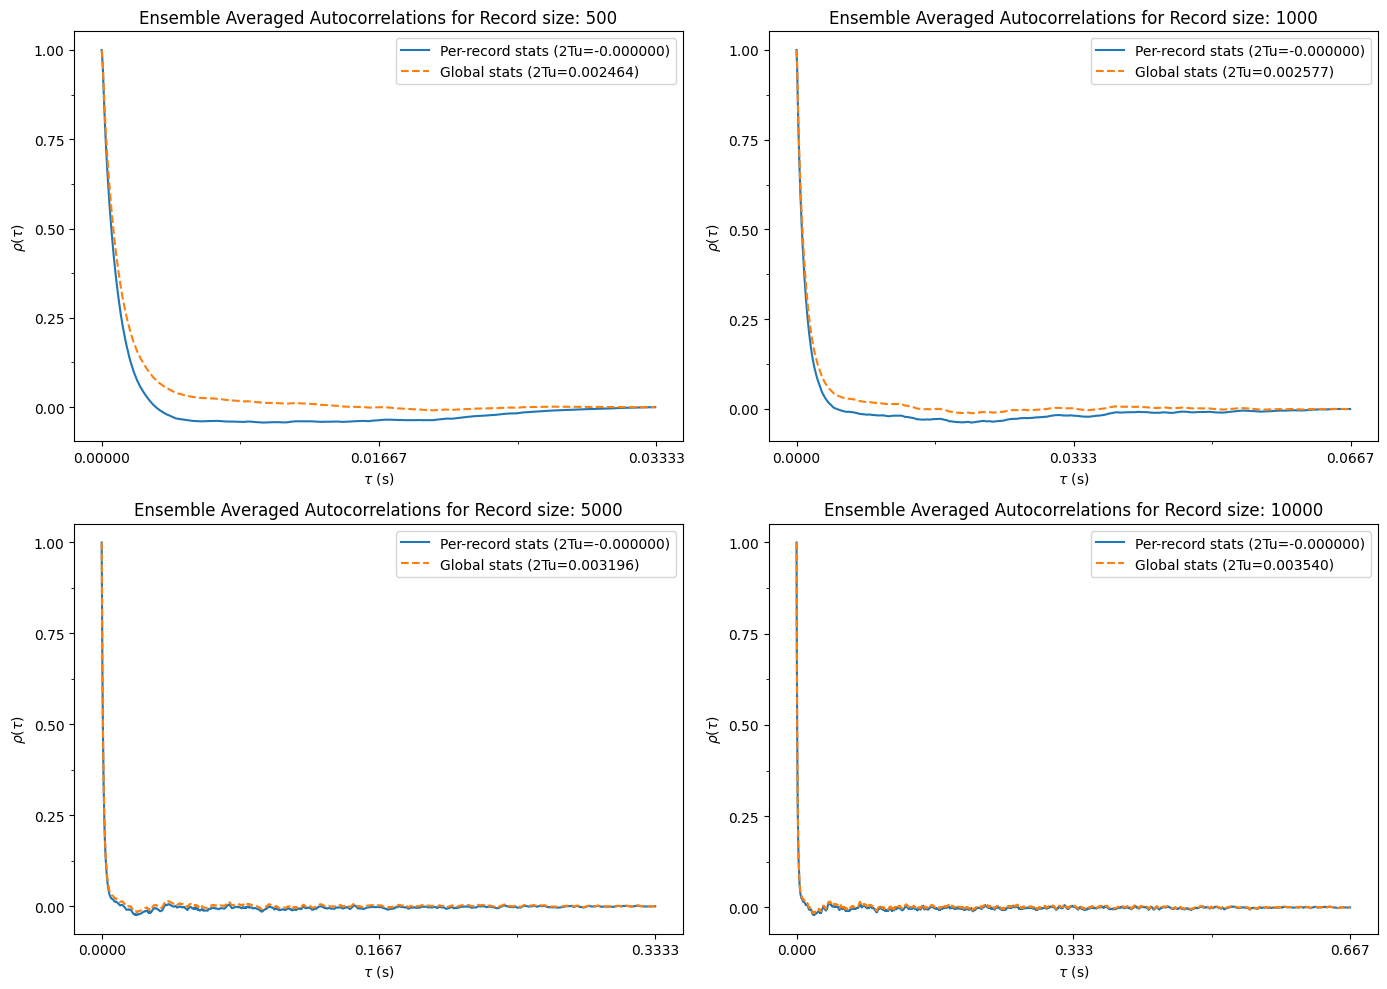

In [17]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for idx, rec_size in enumerate(record_sizes):
    ax = axes[idx]
    acorr_per_record, Tu_per_record = results[rec_size]['per_record']
    acorr_global, Tu_global = results[rec_size]['global']
    lags = np.arange(len(acorr_per_record)) / 15000
    ax.plot(lags, acorr_per_record, label=f'Per-record stats (2Tu={Tu_per_record/15000:.6f})')
    ax.plot(lags, acorr_global, label=f'Global stats (2Tu={Tu_global/15000:.6f})', linestyle='--')
    ax.set_title(f'Ensemble Averaged Autocorrelations for Record size: {rec_size}')
    ax.set_xlabel('$\\tau$ (s)')  # Greek letter tau
    ax.set_ylabel('$\\rho(\\tau)$')  # Greek letter rho with tau
    ax.legend()
    ax.yaxis.set_major_locator(MultipleLocator(0.25))  # Major ticks every 0.25
    ax.yaxis.set_minor_locator(MultipleLocator(0.125))  # Minor ticks every 0.125
    ax.xaxis.set_major_locator(MultipleLocator(rec_size/(2 * 15000)))  # Adjusted for time in seconds
    ax.xaxis.set_minor_locator(MultipleLocator(rec_size/(4 * 15000)))  # Adjusted for time in seconds

plt.tight_layout()
plt.show()